## STEP 1: Install Cocodataset

In [4]:
!mkdir -p data
!wget http://images.cocodataset.org/zips/train2017.zip
!unzip train2017.zip -d data

A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file data already exists.
Error occurred while processing: data.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


## STEP 2: Load data

In [ ]:
import matplotlib.pyplot as plt
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
import tensorflow as tf

In [ ]:
images_path = "/content/data/train2017/"

In [ ]:
input_img_paths_coco = sorted([os.path.join(images_path, fname) for fname in os.listdir(images_path)])
len(input_img_paths_coco)

116951

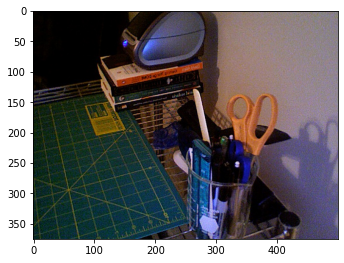

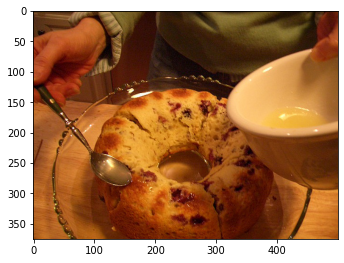

In [ ]:
n_images = 2
for i in np.random.randint(0,len(input_img_paths_coco),n_images):
  fig = plt.figure(figsize = (12,6))
  fig.tight_layout()
  plt.subplot(1,2,1)
  img = plt.imread(input_img_paths_coco[i])
  plt.imshow(img)

In [32]:
from PIL import Image
x = []
y = []
img_size = (120,120)
for image_file in input_img_paths_coco[:2500]:
    img = load_img(image_file, target_size=img_size,color_mode = 'grayscale')
    img = np.array(img)
    x.append( np.expand_dims(img, 2)  )

    img1 = load_img(image_file, target_size=img_size)
    img1 = np.array(img1)/255
    y.append( img1 )

In [33]:
# Construct tf.data.Dataset object
batch_size = 5
dataset = tf.data.Dataset.from_tensor_slices( ( np.array(x) , np.array(y) ) )
dataset = dataset.batch( batch_size )

In [ ]:
# class Data_Generator(tf.keras.utils.Sequence):
#   def __init__(self,batch_size,img_size,input_img_path):
#     self.batch_size = batch_size
#     self.img_size = img_size 
#     self.input_img_path = input_img_path

#   def __len__(self):
#     return len(self.input_img_path) // self.bath_size

#   def __getitem__(self,idx):
#     i = idx *  self.batch_size
#     batch_input_img_path = self.input_img_path[i:i+self.batch_size]
    
#     x = np.zeros((self.batch_size,) + self.img_size + (1,),dtype = 'float32')
#     y = np.zeros((self.batch_size,) + self.img_size + (3,),dtype = 'float32')

#     for i,path in enumerate(batch_input_img_path):
#       img = load_img(path, target_size=self.img_size,color_mode = 'grayscale')
#       img = np.array(img)
#       # img[img!=0] = 1
#       x[i] = np.expand_dims(img, 2) 

#     for i,path in enumerate(batch_input_img_path):
#       img = load_img(path, target_size=self.img_size)
#       img = np.array(img)/255
#       y[i] = img 

#     return x,y

In [ ]:
# batch_size = 16
# img_size = (256,256)
# train_gen = Data_Generator(batch_size, img_size, input_img_paths_coco)
# x,y= train_gen.__getitem__(0)
# print(x.shape,y.shape)

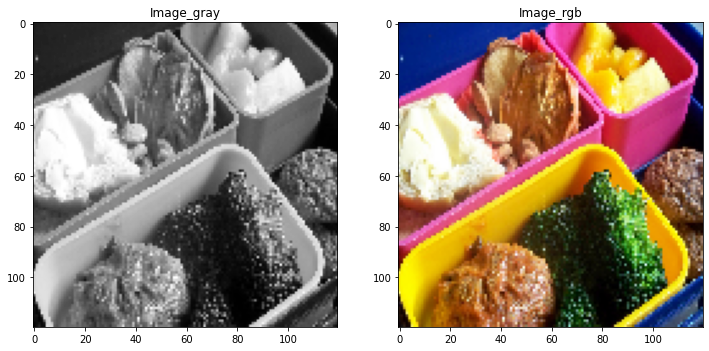

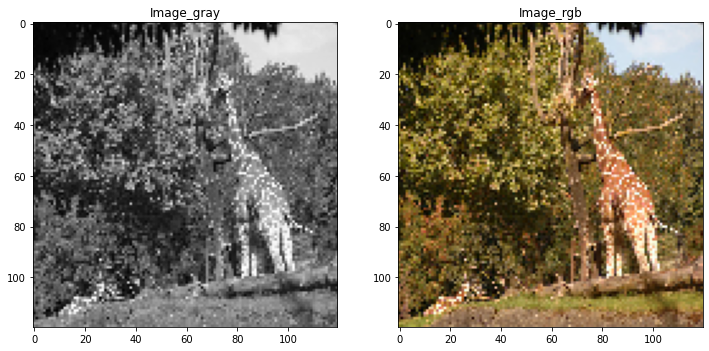

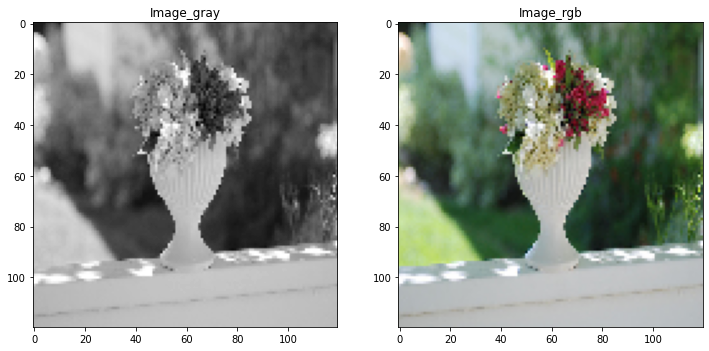

In [34]:
n_images = 3
for i in range(n_images):
    fig = plt.figure(figsize = (12,6))
    fig.tight_layout()
    plt.subplot(1,2,1)
    plt.imshow(x[i].squeeze(),cmap='gray')
    plt.title('Image_gray')

    plt.subplot(1,2,2)
    plt.imshow(y[i].squeeze())
    plt.title('Image_rgb')
    plt.show()
    print()

## STEP 3: Architecture GAN

In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

### STEP 3.1: Generator

#### STEP 3.1.1: Build architecture Encoder-Decoder or Unet or VGG16-Unet 

In [ ]:
def get_generator_model():

    inputs = tf.keras.layers.Input( shape=( 120 , 120 , 1 ) )

    conv1 = tf.keras.layers.Conv2D( 16 , kernel_size=( 5 , 5 ) , strides=1 )( inputs )
    conv1 = tf.keras.layers.LeakyReLU()( conv1 )
    conv1 = tf.keras.layers.Conv2D( 32 , kernel_size=( 3 , 3 ) , strides=1)( conv1 )
    conv1 = tf.keras.layers.LeakyReLU()( conv1 )
    conv1 = tf.keras.layers.Conv2D( 32 , kernel_size=( 3 , 3 ) , strides=1)( conv1 )
    conv1 = tf.keras.layers.LeakyReLU()( conv1 )

    conv2 = tf.keras.layers.Conv2D( 32 , kernel_size=( 5 , 5 ) , strides=1)( conv1 )
    conv2 = tf.keras.layers.LeakyReLU()( conv2 )
    conv2 = tf.keras.layers.Conv2D( 64 , kernel_size=( 3 , 3 ) , strides=1 )( conv2 )
    conv2 = tf.keras.layers.LeakyReLU()( conv2 )
    conv2 = tf.keras.layers.Conv2D( 64 , kernel_size=( 3 , 3 ) , strides=1 )( conv2 )
    conv2 = tf.keras.layers.LeakyReLU()( conv2 )

    conv3 = tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1 )( conv2 )
    conv3 = tf.keras.layers.LeakyReLU()( conv3 )
    conv3 = tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 )( conv3 )
    conv3 = tf.keras.layers.LeakyReLU()( conv3 )
    conv3 = tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 )( conv3 )
    conv3 = tf.keras.layers.LeakyReLU()( conv3 )

    bottleneck = tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='tanh' , padding='same' )( conv3 )

    concat_1 = tf.keras.layers.Concatenate()( [ bottleneck , conv3 ] )
    conv_up_3 = tf.keras.layers.Conv2DTranspose( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( concat_1 )
    conv_up_3 = tf.keras.layers.Conv2DTranspose( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( conv_up_3 )
    conv_up_3 = tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu' )( conv_up_3 )

    concat_2 = tf.keras.layers.Concatenate()( [ conv_up_3 , conv2 ] )
    conv_up_2 = tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( concat_2 )
    conv_up_2 = tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( conv_up_2 )
    conv_up_2 = tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu' )( conv_up_2 )

    concat_3 = tf.keras.layers.Concatenate()( [ conv_up_2 , conv1 ] )
    conv_up_1 = tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu')( concat_3 )
    conv_up_1 = tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu')( conv_up_1 )
    conv_up_1 = tf.keras.layers.Conv2DTranspose( 3 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu')( conv_up_1 )

    model = tf.keras.models.Model( inputs , conv_up_1 )
    return model


In [ ]:
# def get_generator_model():
#   inputs = Input(shape= (img_size[0], img_size[1], 1))
#   conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
#   conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
#   pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

#   conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
#   conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
#   pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

#   conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
#   conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
#   pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

#   conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
#   conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
#   drop4 = Dropout(0.5)(conv4)
#   pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

#   conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
#   conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
#   drop5 = Dropout(0.5)(conv5)

#   up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
#   merge6 = concatenate([drop4,up6], axis = 3)
#   conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
#   conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

#   up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
#   merge7 = concatenate([conv3,up7], axis = 3)
#   conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
#   conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

#   up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
#   merge8 = concatenate([conv2,up8], axis = 3)
#   conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
#   conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

#   up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
#   merge9 = concatenate([conv1,up9], axis = 3)
#   conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
#   conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
#   conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
#   conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

#   model = Model(inputs, conv10)
#   return model

### STEP 3.2: Discriminator

In [ ]:
def get_discriminator_model():
    layers = [
        tf.keras.layers.Conv2D( 32 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu' , input_shape=( 120 , 120 , 3 ) ),
        tf.keras.layers.Conv2D( 32 , kernel_size=( 5, 5 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1, activation='relu'  ),
        tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D( 256 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.Conv2D( 256 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense( 512, activation='relu'  )  ,
        tf.keras.layers.Dense( 128 , activation='relu' ) ,
        tf.keras.layers.Dense( 16 , activation='relu' ) ,
        tf.keras.layers.Dense( 1 , activation='sigmoid' ) 
    ]
    model = tf.keras.models.Sequential( layers )
    return model


## STEP 4: Loss Function

In [ ]:
from tensorflow.keras.losses import BinaryCrossentropy,MeanSquaredError

In [ ]:
cross_entropy = BinaryCrossentropy()
mse = MeanSquaredError()

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output) - tf.random.uniform( shape=real_output.shape , maxval=0.1 ) , real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output) + tf.random.uniform( shape=fake_output.shape , maxval=0.1  ) , fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output , real_y):
    real_y = tf.cast( real_y , 'float32' )
    return mse( fake_output , real_y )

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

generator = get_generator_model()
discriminator = get_discriminator_model()

## STEP 5: Training

In [ ]:
@tf.function
def train_step( input_x , real_y ):
   
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate an image -> G( x )
        generated_images = generator( input_x , training=True)
        # Probability that the given image is real -> D( x )
        real_output = discriminator( real_y, training=True)
        # Probability that the given image is the one generated -> D( G( x ) )
        generated_output = discriminator(generated_images, training=True)
        
        # L2 Loss -> || y - G(x) ||^2
        gen_loss = generator_loss( generated_images , real_y )
        # Log loss for the discriminator
        disc_loss = discriminator_loss( real_output, generated_output )
        
        losses["D"].append(disc_loss)
        losses["G"].append(gen_loss)
    #tf.keras.backend.print_tensor( tf.keras.backend.mean( gen_loss ) )
    #tf.keras.backend.print_tensor( gen_loss + disc_loss )
    
    # Compute the gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Optimize with Adam
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

generator.compile(
    optimizer=generator_optimizer,
    loss=generator_loss,
    metrics=['accuracy']
)

discriminator.compile(
    optimizer=discriminator_optimizer,
    loss=discriminator_loss,
    metrics=['accuracy']
)


In [ ]:
# Please have a look at the Notebook in pdf form that was train on 150 epoc.
num_epochs = 10
losses = {"D":[], "G":[]}
for e in range( num_epochs ):
    print("Running epoch : ", e )
    for ( x , y ) in dataset:
        # Here ( x , y ) represents a batch from our training dataset.
        # print( x.shape )
        train_step(x,y)

Running epoch :  0
Running epoch :  1
Running epoch :  2
Running epoch :  3
Running epoch :  4
Running epoch :  5
Running epoch :  6
Running epoch :  7
Running epoch :  8
Running epoch :  9


In [ ]:
ya = generator( x[0 : ] ).numpy()

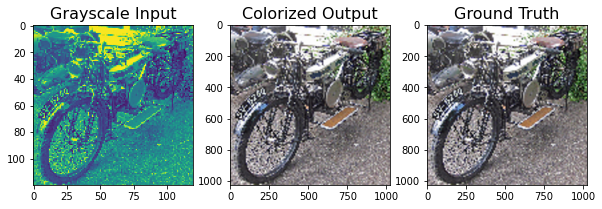

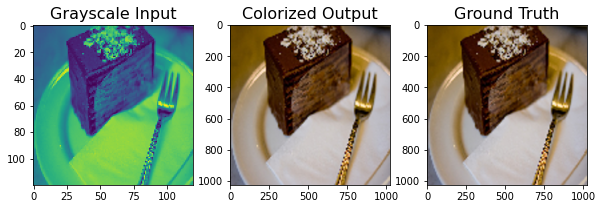

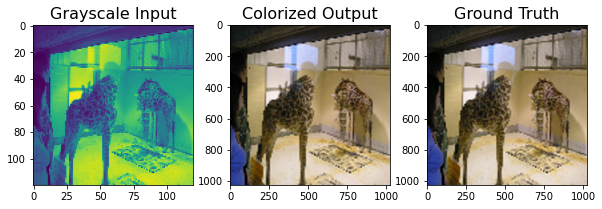

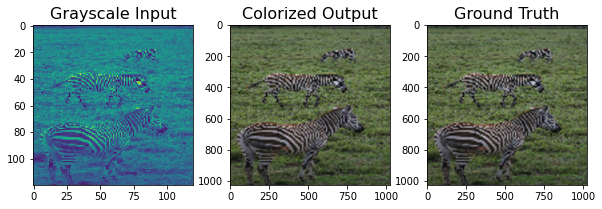

In [39]:
for i in range(11, 33, 7):
  plt.figure(figsize=(10,10))
  or_image = plt.subplot(3,3,1)
  or_image.set_title('Grayscale Input', fontsize=16)
  plt.imshow( (x[i].squeeze()))

  in_image = plt.subplot(3,3,2)    
  image = Image.fromarray( ( ya[i] * 255 ).astype( 'uint8' ) ).resize( ( 1024 , 1024 ) )
  image = np.asarray( image )
  in_image.set_title('Colorized Output', fontsize=16)
  plt.imshow( image )

  ou_image = plt.subplot(3,3,3)
  image = Image.fromarray( ( y[i] * 255 ).astype( 'uint8' ) ).resize( ( 1024 , 1024 ) )
  ou_image.set_title('Ground Truth', fontsize=16)
  plt.imshow( image )

  plt.show()